In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from churn_training import evaluate_model
from churn_training import prepare_data
from churn_training import train_model
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

/home/pt7481/.local/share/virtualenvs/orchestration-QWRVKjDy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CUSTOMER_CHURN_DATASET = "../../../data/customer_churn_0.csv"
TARGET_COLUMN = "Churn"
df = pd.read_csv(CUSTOMER_CHURN_DATASET)

In [3]:
df.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

In [4]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
df.shape

(1050, 14)

In [6]:
len(df.isnull().sum().loc[lambda x: x > 0])

0

In [7]:
df.duplicated().sum()

np.int64(87)

In [8]:
def plot_numerical_variables(numerical_df):
    numerical_cols = numerical_df.select_dtypes(include=["float", "int"]).columns

    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    _, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, col in enumerate(numerical_cols):
        sns.histplot(data=numerical_df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f"Distribution of {col}")
        axes[idx].tick_params(axis="x", rotation=45)
    # Hide any unused subplots
    for ax in axes[len(numerical_cols) :]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

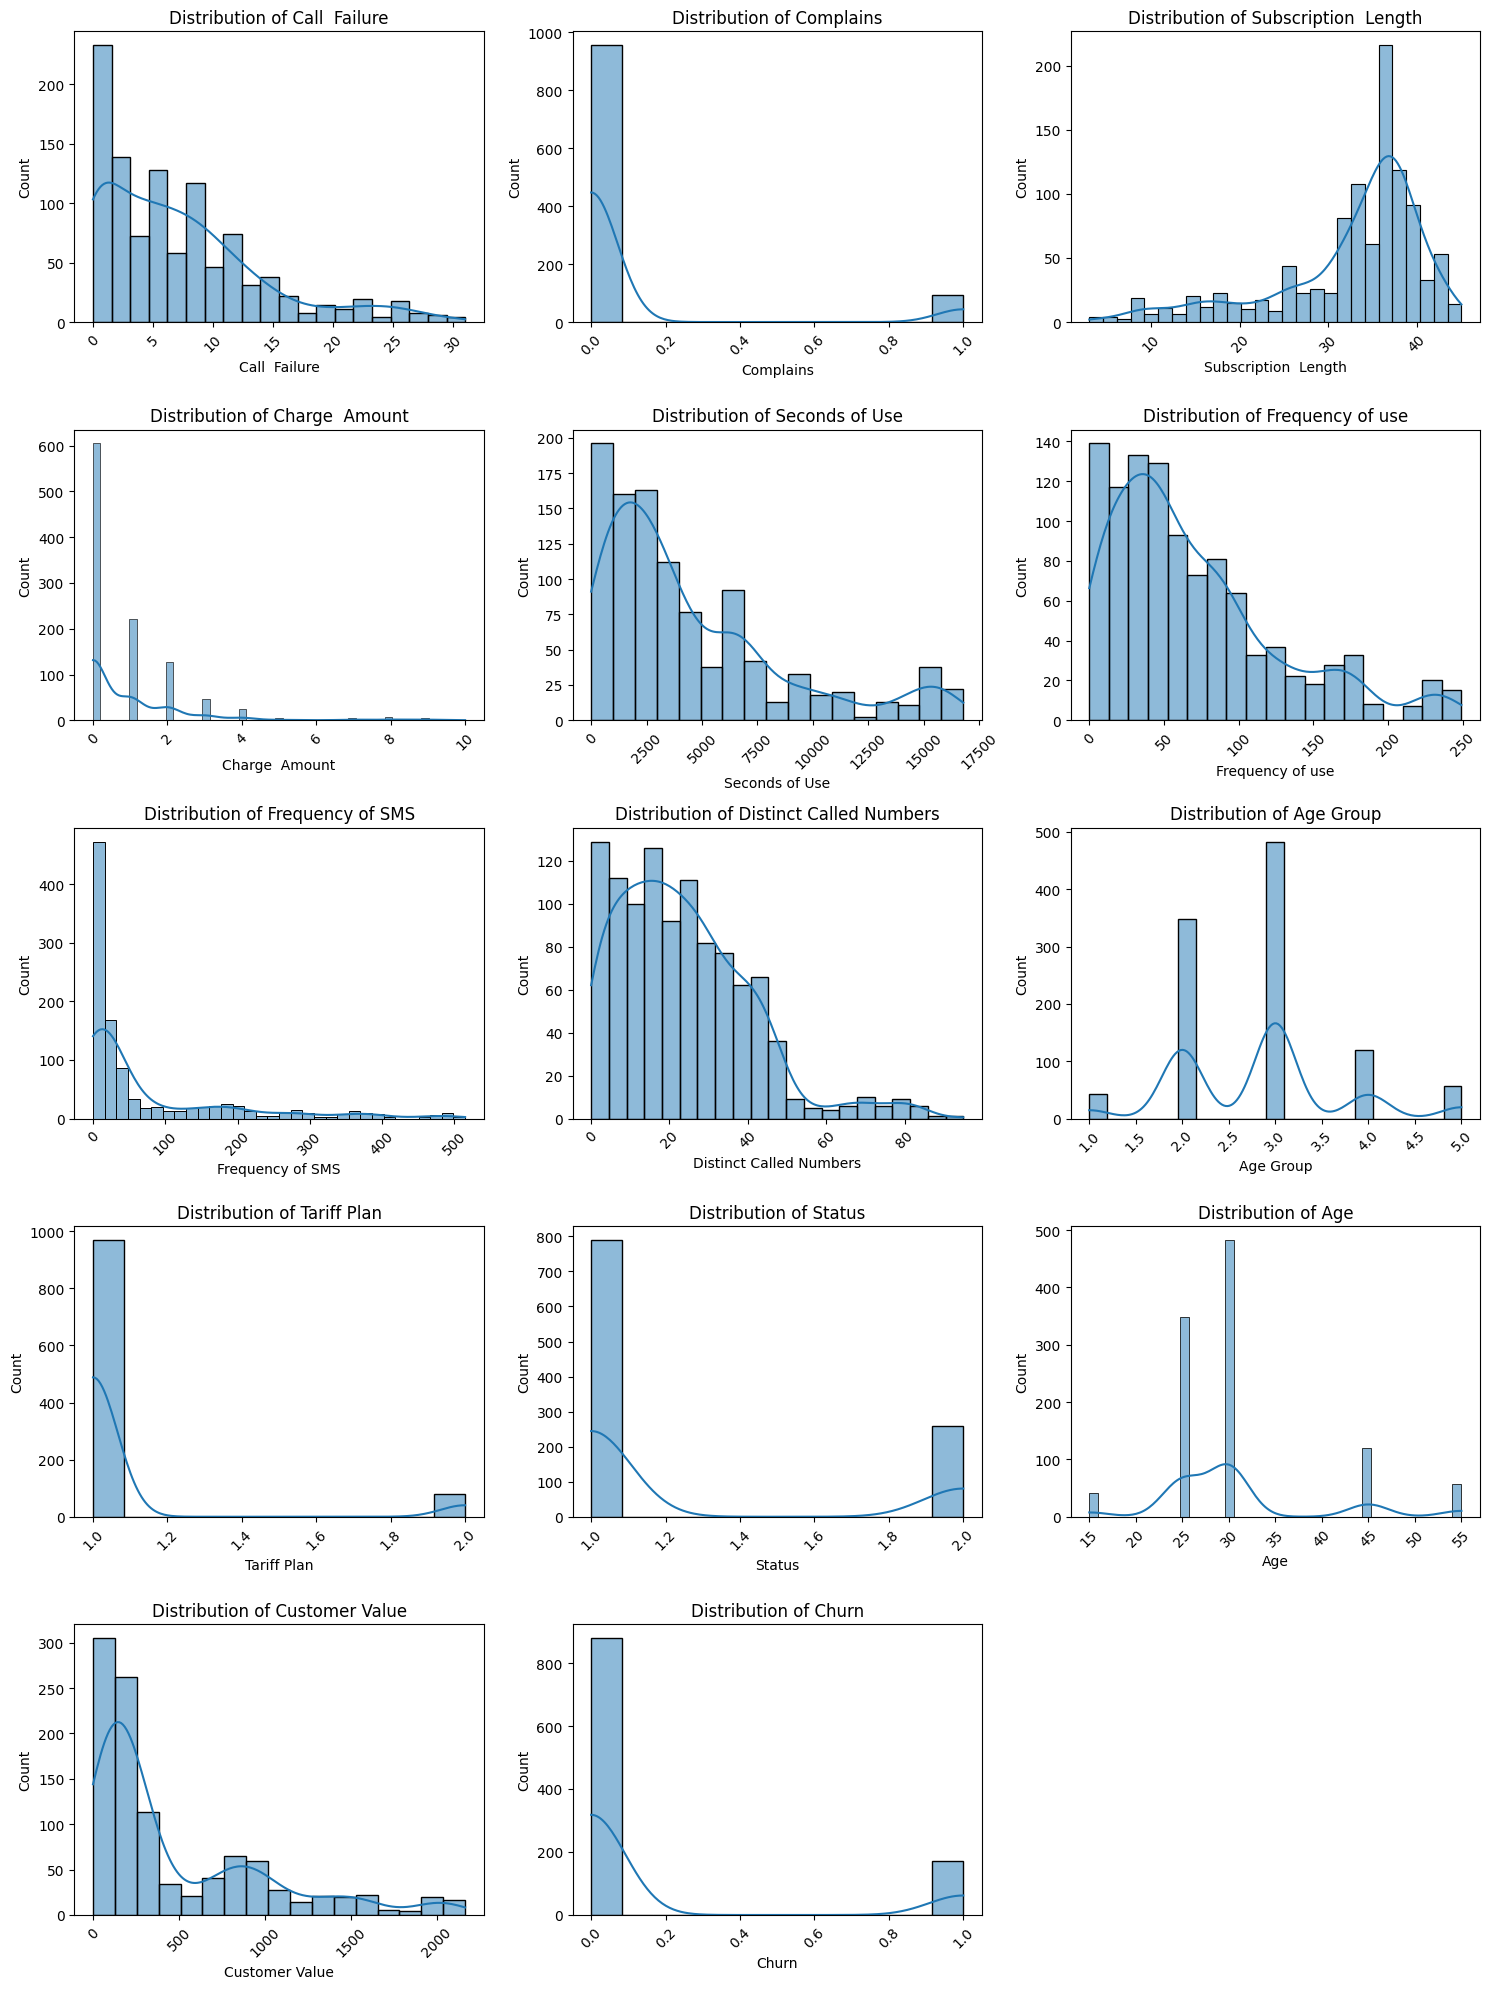

In [9]:
plot_numerical_variables(df)

In [10]:
print(Path().resolve().parents[2])
env_path = Path().resolve().parents[2] / ".env"
load_dotenv(dotenv_path=env_path)
MLFLOW_TRACKING_URI = os.getenv(
    "MLFLOW_TRACKING_URI"
)  # This should be set in your .env file
print(f"MLFLOW_TRACKING_URI: {MLFLOW_TRACKING_URI}")
if not MLFLOW_TRACKING_URI:
    raise ValueError("MLFLOW_TRACKING_URI is not set. Please check your .env file.")

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("mlops-churn-pipeline")

/home/pt7481/mlops-churn-pipeline
MLFLOW_TRACKING_URI: http://mlops-churn-pipeline-alb-1918604706.us-east-2.elb.amazonaws.com:5000


2025/07/17 12:46:35 INFO mlflow.tracking.fluent: Experiment with name 'mlops-churn-pipeline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlops-churn-pipeline/mlflow/1', creation_time=1752781597015, experiment_id='1', last_update_time=1752781597015, lifecycle_stage='active', name='mlops-churn-pipeline', tags={}>

In [11]:
X, y = prepare_data(df)

In [12]:
X.shape, y.shape

((1050, 10), (1050,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((840, 10), (210, 10), (840,), (210,))

In [15]:
base_params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.1,
    "random_state": 42,
}
clf = train_model(X_train, y_train, base_params)

In [16]:
# To run hyperparameter tuning, import the function and uncomment the following line:
# clf = tune_model_with_cv(X_train, y_train)

In [17]:
# Train final model with best tuned hyperparameters to-date
# These parameters are based on the best results from previous tuning runs
# X_test precision/recall/f1: 0.92 0.81 0.86
best_params_to_date = {
    "n_estimators": 352,
    "learning_rate": 0.07154324375438634,
    "max_depth": 7,
    "min_child_weight": 1,
    "gamma": 0.23500630396472585,
    "subsample": 0.9472361823473306,
    "colsample_bytree": 0.6149847610884563,
    "reg_alpha": 0.029080723124195962,
    "reg_lambda": 1.9394489642211972,
}
clf = train_model(X_train, y_train, best_params_to_date)

In [18]:
# First evaluate tuned model on training data to check for bias
evaluate_model(clf, X_train, y_train, "X_train")

Logging model to MLflow...


Successfully registered model 'XGBoostChurnModel'.
2025/07/17 12:46:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostChurnModel, version 1
Created version '1' of model 'XGBoostChurnModel'.
2025/07/17 12:46:47 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-f5331b0bb985485a9be0464b40a8dc8d
2025/07/17 12:46:47 INFO mlflow.tracking.fluent: Use `mlflow.set_active_model` to set the active model to a different one if needed.
2025/07/17 12:46:47 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.
2025/07/17 12:46:47 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2025/07/17 12:46:47 INFO mlflow.models.evaluation.default_evalua


Evaluation Results for X_train:
Log Loss: 0.040
Precision Score: 0.977
Recall Score: 0.984
Accuracy: 0.994

🏃 View run upset-trout-836 at: http://mlops-churn-pipeline-alb-1918604706.us-east-2.elb.amazonaws.com:5000/#/experiments/1/runs/371547ce0254489390de41a8dc765a68
🧪 View experiment at: http://mlops-churn-pipeline-alb-1918604706.us-east-2.elb.amazonaws.com:5000/#/experiments/1


<Figure size 1050x700 with 0 Axes>

In [19]:
# Next evaluate tuned model on test data to check for variance
evaluate_model(
    clf,
    X_test,
    y_test,
    "X_test",
    log_model=True,
    log_model_X_train=X_train,
    log_model_y_train=y_train,
)

Logging model to MLflow...


Registered model 'XGBoostChurnModel' already exists. Creating a new version of this model...
2025/07/17 12:46:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostChurnModel, version 2
Created version '2' of model 'XGBoostChurnModel'.
2025/07/17 12:46:57 INFO mlflow.tracking.fluent: Active model is set to the logged model with ID: m-fbb0748ada4d408c9c183bf60c4fe349
2025/07/17 12:46:57 INFO mlflow.tracking.fluent: Use `mlflow.set_active_model` to set the active model to a different one if needed.
2025/07/17 12:46:57 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2025/07/17 12:46:57 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2025/07/17 12:47:00 WARNING mlflow.models.evaluation.evaluators.shap: SHAP or matplotlib package is not installed, so model explainability insights


Evaluation Results for X_test:
Log Loss: 0.169
Precision Score: 0.854
Recall Score: 0.833
Accuracy: 0.938

Logging training data with model...
Setting model alias to 'staging' in MLflow registry...

🏃 View run efficient-foal-689 at: http://mlops-churn-pipeline-alb-1918604706.us-east-2.elb.amazonaws.com:5000/#/experiments/1/runs/fa79791449294c609ec02d2bfdf51fbd
🧪 View experiment at: http://mlops-churn-pipeline-alb-1918604706.us-east-2.elb.amazonaws.com:5000/#/experiments/1


<Figure size 1050x700 with 0 Axes>